In [16]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import glob
import re
import os
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)

def label_sample(x):
    if 'HS' in x:
        return 'High salt'
    elif 'Frag' in x:
        return 'Fragmented'
    elif re.search('N[aA]', x):
        return 'Alkaline hydrolysis'
    elif re.search('L[12]',x):
        return 'PolyA-selected'
    elif re.search('Exo|ED|DE', x):
        return 'Exonuclease I'
    elif 'All' in x:
        return 'Untreated'
    else:
        return 'Unfragmented'
    
def read_dedup(x):
    samplename = os.path.basename(x)
    dedup_file = x + '/Combined/primary.deduplicated.dedup_metric'
    if os.path.isfile(dedup_file)  and os.stat(dedup_file).st_size != 0:
        return pd.read_table(dedup_file,
                         skiprows = 6, nrows = 1)\
            .pipe(pd.melt)\
            .assign(samplename = samplename) 

In [22]:
project_path = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map'
samples = glob.glob(project_path + '/*R1_001')
samples = filter(lambda x: re.search('Q[cC][fF]', x), samples)
samples = filter(lambda x:  not re.search('L[12]', x), samples)
samples = list(samples)

df = map(read_dedup, samples)
df = filter(lambda x: x is not None, df)


y = 'ESTIMATED_LIBRARY_SIZE'
x = 'READ_PAIRS_EXAMINED'
df = pd.concat(df) \
    .pipe(lambda d: d[d.variable.str.contains("^%s$|^%s$" %(y,x))]) \
    .assign(prep = lambda d: d.samplename.map(label_sample)) \
    .assign(value = lambda d: d['value'].astype(int))\
    .pipe(pd.pivot_table, 
              columns = 'variable', 
              values = 'value',
              index = ['samplename', 'prep'])\
    .reset_index()
df.head()

variable,samplename,prep,ESTIMATED_LIBRARY_SIZE,READ_PAIRS_EXAMINED
0,QCF1_R1_001,Unfragmented,299326,1303952
1,QCF2_R1_001,Unfragmented,352664,1672014
2,Qcf10_R1_001,Unfragmented,367874,566922
3,Qcf4_R1_001,Unfragmented,271336,659257
4,Qcf5_R1_001,Unfragmented,231661,446012


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


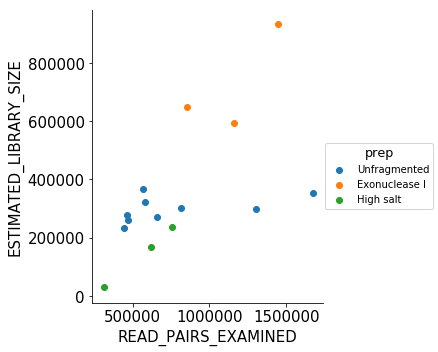

In [23]:
p = sns.FacetGrid(data = df\
                      .pipe(lambda d: d[~d.prep.str.contains('Unt|Al|^Fra')]), 
                  hue = 'prep',size = 5)
#p.map(sns.regplot, x, y,, hue='prep', size = 5)
#      scatter_kws = {'alpha':1},
#      ci=None)
p.map(plt.scatter, x,y)
p.add_legend()
#p.set(xlim = (df[x].min()-100000,df[x].max()),
#     ylim = (df[y].min()-1000000, df[y].max()))

In [24]:
df = pd.concat(map(read_dedup, samples)) \
    .pipe(lambda d: d[d.variable.str.contains("PERCEN")]) \
    .assign(prep = lambda d: d.samplename.map(label_sample)) \
    .sort_values('value')
df

,variable,value,samplename,prep
8,PERCENT_DUPLICATION,0.056994,Qcf_NA2_R1_001,Alkaline hydrolysis
8,PERCENT_DUPLICATION,0.070474,Qcf_All1_R1_001,Untreated
8,PERCENT_DUPLICATION,0.102279,Qcf_Na1_R1_001,Alkaline hydrolysis
8,PERCENT_DUPLICATION,0.147922,Qcf_Frag1_R1_001,Fragmented
8,PERCENT_DUPLICATION,0.444108,Qcf_ED1_R1_001,Exonuclease I
8,PERCENT_DUPLICATION,0.490064,Qcf10_R1_001,Unfragmented
8,PERCENT_DUPLICATION,0.491696,Qcf_Exo1_R1_001,Exonuclease I
8,PERCENT_DUPLICATION,0.513787,Qcf9_R1_001,Unfragmented
8,PERCENT_DUPLICATION,0.517283,Qcf_Frag2_R1_001,Fragmented
8,PERCENT_DUPLICATION,0.538991,Qcf8_R1_001,Unfragmented


(0.5, 1)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


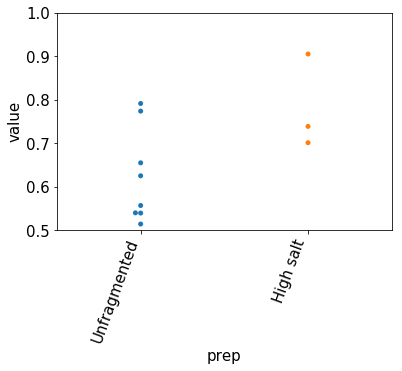

In [25]:
ax = plt.subplot() 
sns.swarmplot(data = df.pipe(lambda d: d[d.prep.str.contains('Unf|Hi')]), x = 'prep', y = 'value', ax = ax)
xt = ax.set_xticklabels(ax.get_xticklabels(), rotation = 70, ha = 'right')
ax.set_ylim(0.5,1)

In [32]:
from scipy.stats import ttest_ind
ttest_ind(df.query('prep == "Unfragmented"')['value'].values,
         df.query('prep == "High salt"')['value'].values)

Ttest_indResult(statistic=-2.3396594175430017, pvalue=0.041363571647133453)